In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from tqdm import tqdm
import timm
import torchattacks
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import detectors

In [11]:
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std =  (0.2023, 0.1994, 0.201)

transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=norm_mean, std=norm_std)
])

batch_size = 64
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
num_classes = 10

In [ ]:
# model = timm.create_model('resnet18', pretrained=True, num_classes=num_classes)
# model.load_state_dict(torch.load("cifar10_model.pth"))

C:\Users\Maciej\AppData\Local\Temp\ipykernel_12520\4126133730.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cifar10_model.pth"))


<All keys matched successfully>

In [4]:
model = timm.create_model('resnet18_cifar10', pretrained=True)

In [64]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda


In [12]:
eps = 0.02
fgsm = torchattacks.FGSM(model, eps=eps)
fgsm.set_normalization_used(mean=norm_mean, std=norm_std)
bim = torchattacks.BIM(model, eps=eps, alpha=0.01, steps=10)
bim.set_normalization_used(mean=norm_mean, std=norm_std)
pgd = torchattacks.PGD(model, eps=eps, alpha=0.01, steps=40)
pgd.set_normalization_used(mean=norm_mean, std=norm_std)

In [65]:
def evaluate_attack(attack, dataloader):
    model.eval()
    correct = 0
    total = 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        if attack:
            adv_inputs = attack(inputs, labels)
        else:
            adv_inputs = inputs

        outputs = model(adv_inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [66]:
clean_accuracy = evaluate_attack(None, testloader)
print(f'Clean data accuracy: {clean_accuracy:.2f}%')

Clean data accuracy: 94.98%


In [15]:
fgsm_accuracy = evaluate_attack(fgsm, testloader)
print(f'FGSM accuracy: {fgsm_accuracy:.2f}%')

FGSM accuracy: 30.06%


In [11]:
bim_accuracy = evaluate_attack(bim, testloader)
print(f'BIM accuracy: {bim_accuracy:.2f}%')

BIM accuracy: 0.07%


In [12]:
pgd_accuracy = evaluate_attack(pgd, testloader)
print(f'PGD accuracy: {pgd_accuracy:.2f}%')

PGD accuracy: 0.01%


In [36]:
def denormalize(img):
    img_normalized = img.clone()
    for c in range(3):
        img_normalized[c] = img[c] * norm_std[c] + norm_mean[c]
    img_normalized = torch.clamp(img_normalized, 0, 1)
    return img_normalized

In [37]:
def visualize(dataset, attack=None):
    model.eval()
    
    for img, label in dataset:
        img = img.unsqueeze(0).cuda()
        label = torch.tensor([label]).cuda()

        clean_outputs = model(img)
        _, clean_preds = torch.max(clean_outputs, 1)

        adv_images = attack(img, label) if attack is not None else img
        adv_outputs = model(adv_images)
        _, adv_preds = torch.max(adv_outputs, 1)

        mask = adv_images - img

        fig, axes = plt.subplots(1, 3, figsize=(12, 4))
        fig.subplots_adjust(wspace=0.5)

        axes[0].imshow(np.transpose(denormalize(img[0]).cpu().numpy(), (1, 2, 0)))
        axes[0].set_title(f"Clean Image\nPred: {clean_preds[0].item()}\nTrue: {label.item()}")
        axes[0].axis('off')

        axes[1].imshow(np.transpose(denormalize(adv_images[0]).cpu().numpy(), (1, 2, 0)))
        axes[1].set_title(f"Adversarial Image\nPred: {adv_preds[0].item()}")
        axes[1].axis('off')

        axes[2].imshow(np.transpose(denormalize(mask[0]).cpu().numpy(), (1, 2, 0)))
        axes[2].set_title("Perturbation (Mask)")
        axes[2].axis('off')

        plt.show()

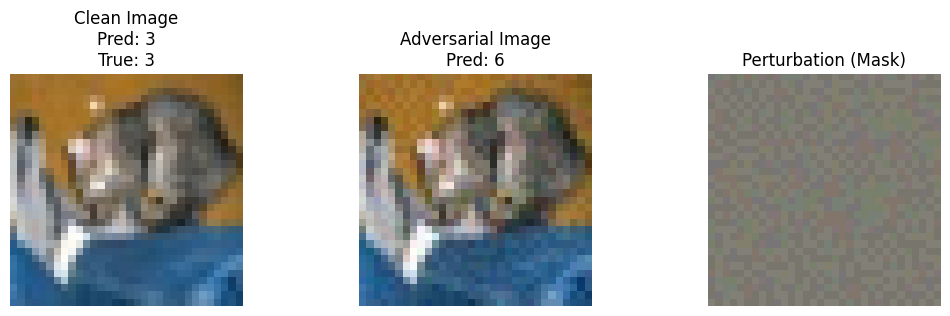

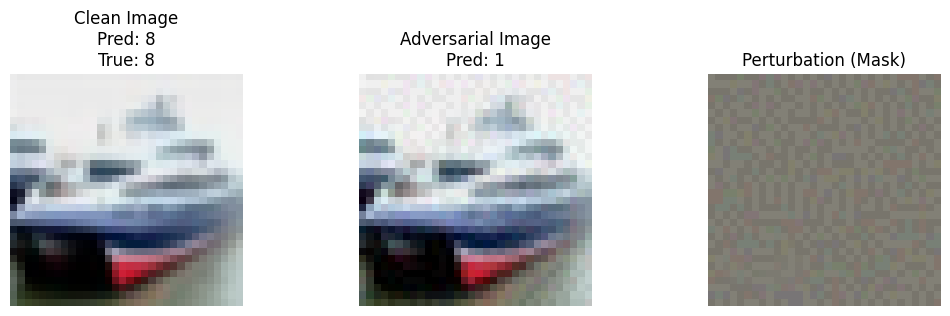

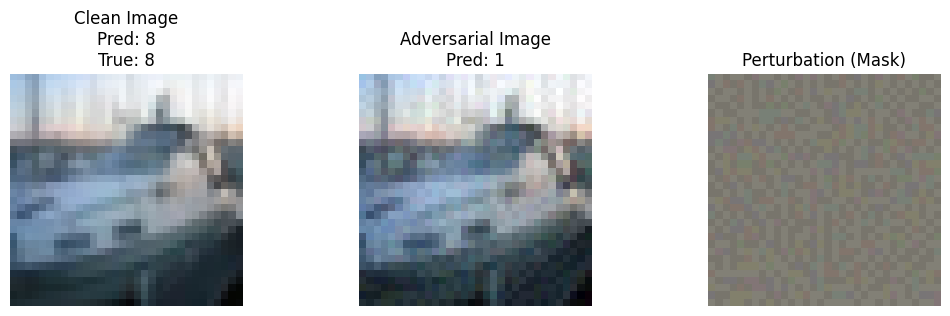

In [38]:
visualize([testset[i] for i in range(0, 3)], attack=fgsm)

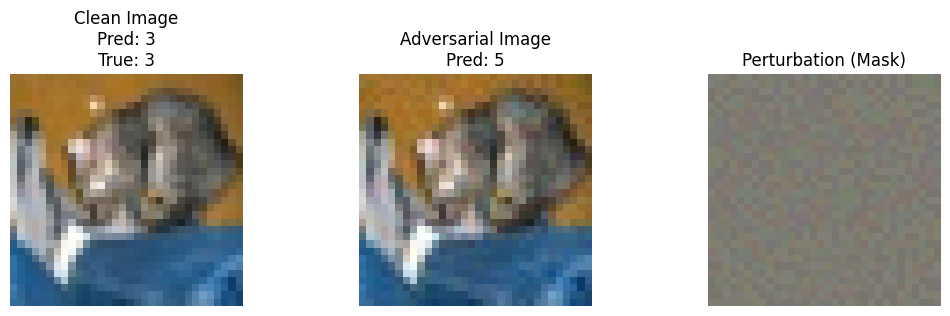

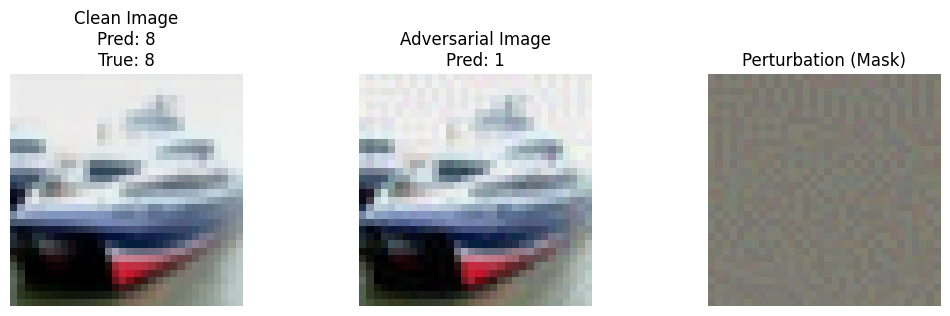

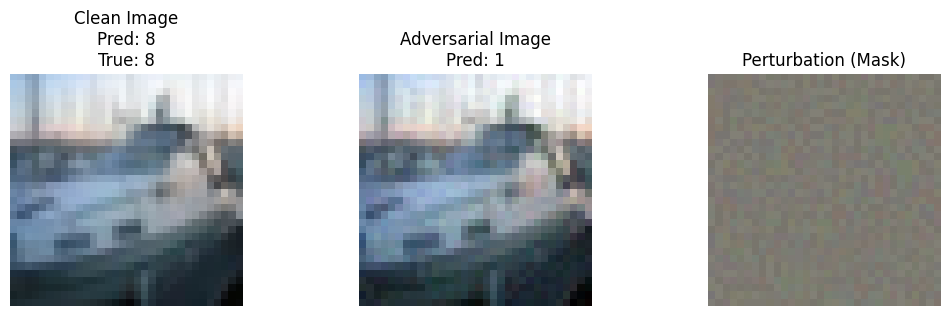

In [39]:
visualize([testset[i] for i in range(0, 3)], attack=bim)

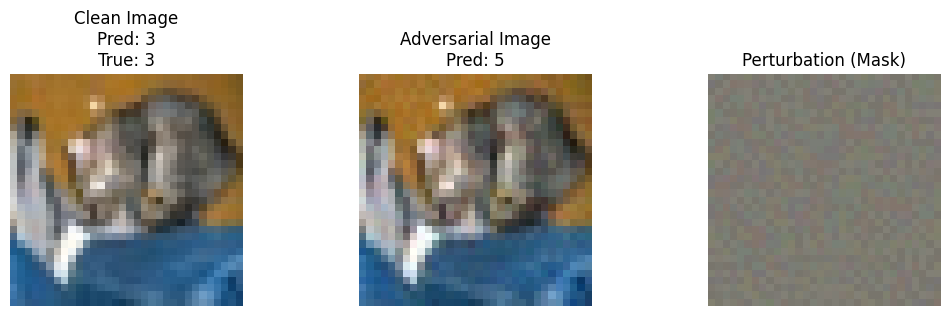

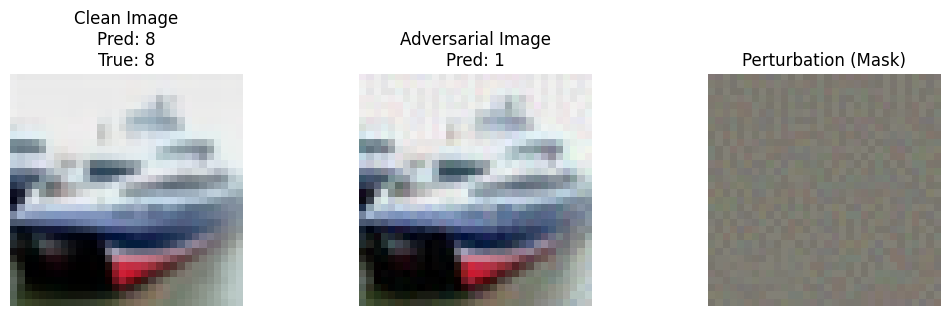

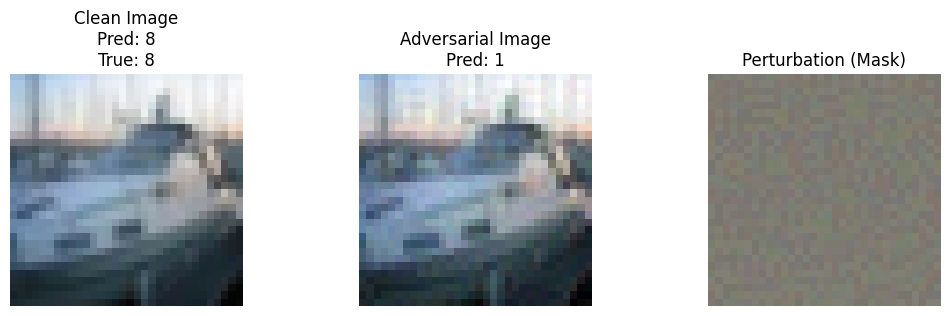

In [40]:
visualize([testset[i] for i in range(0, 3)], attack=pgd)

In [ ]:
print(f'Clean data accuracy: {evaluate_attack(None, trainloader):.2f}%')

Clean data accuracy: 100.00%


In [75]:
class AdversarialDataset(torch.utils.data.Dataset):
    def __init__(self, dataloader, model, attack):
        self.adversarial_images = []
        self.labels = []
        self.model = model
        
        model.eval()

        for inputs, labels in tqdm(dataloader, desc="Generating Adversarial Dataset"):
            inputs, labels = inputs.to(device), labels.to(device)

            adv_images = attack(inputs, labels)
        
            self.adversarial_images.extend(list(torch.unbind(adv_images.detach().cpu(), dim=0)))
            self.labels.extend(labels.detach().cpu().tolist())

    def __len__(self):
        return len(self.adversarial_images)

    def __getitem__(self, idx):
        return self.adversarial_images[idx], self.labels[idx]

In [76]:
fgsmset = AdversarialDataset(trainloader, model, fgsm)

Generating Adversarial Dataset: 100%|██████████| 782/782 [00:53<00:00, 14.59it/s]


In [82]:
fgsmloader = torch.utils.data.DataLoader(fgsmset, batch_size=batch_size, shuffle=True)

In [83]:
print(f'FGSM dataset accuracy: {evaluate_attack(None, fgsmloader):.2f}%')

FGSM dataset accuracy: 57.89%


In [84]:
combinedset = torch.utils.data.ConcatDataset([trainset, fgsmset])
combinedloader = torch.utils.data.DataLoader(combinedset, batch_size=batch_size, shuffle=True)

In [85]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [86]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    with tqdm(combinedloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        for inputs, labels in tepoch:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(combinedloader)
    print(f"Epoch [{epoch+1}/{num_epochs}] completed. Average Loss: {epoch_loss:.4f}")
model.eval()

Epoch [1/10]: 100%|██████████| 1563/1563 [02:06<00:00, 12.38batch/s, loss=0.41] 


Epoch [1/10] completed. Average Loss: 0.5679


Epoch [2/10]: 100%|██████████| 1563/1563 [02:05<00:00, 12.50batch/s, loss=0.327]


Epoch [2/10] completed. Average Loss: 0.3602


Epoch [3/10]: 100%|██████████| 1563/1563 [02:05<00:00, 12.50batch/s, loss=0.298] 


Epoch [3/10] completed. Average Loss: 0.2545


Epoch [4/10]: 100%|██████████| 1563/1563 [02:10<00:00, 11.96batch/s, loss=0.155] 


Epoch [4/10] completed. Average Loss: 0.1810


Epoch [5/10]: 100%|██████████| 1563/1563 [02:06<00:00, 12.34batch/s, loss=0.0202]


Epoch [5/10] completed. Average Loss: 0.1372


Epoch [6/10]: 100%|██████████| 1563/1563 [02:06<00:00, 12.35batch/s, loss=0.42]   


Epoch [6/10] completed. Average Loss: 0.1091


Epoch [7/10]: 100%|██████████| 1563/1563 [02:06<00:00, 12.36batch/s, loss=0.297]  


Epoch [7/10] completed. Average Loss: 0.0890


Epoch [8/10]: 100%|██████████| 1563/1563 [02:07<00:00, 12.30batch/s, loss=0.0131] 


Epoch [8/10] completed. Average Loss: 0.0755


Epoch [9/10]: 100%|██████████| 1563/1563 [02:06<00:00, 12.37batch/s, loss=0.034]  


Epoch [9/10] completed. Average Loss: 0.0660


Epoch [10/10]: 100%|██████████| 1563/1563 [02:04<00:00, 12.53batch/s, loss=0.0252] 

Epoch [10/10] completed. Average Loss: 0.0588


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_

In [87]:
print(f'FGSM dataset accuracy: {evaluate_attack(None, fgsmloader):.2f}%')

FGSM dataset accuracy: 97.77%
